In [35]:
from dash import Dash, dcc, html, dash_table, ctx
from dash.dependencies import Input, Output, State
import pandas as pd
from datetime import date, timedelta, datetime
import sqlite3
import plotly.graph_objects as go
import plotly.express as px
from ModulScrapeWallstreet import scrape_futureprice, future_price_to_sql, extrapolate_data
import json
import numpy as np
from modules_app import *
from plotly.subplots import make_subplots

In [2]:
def load_dfs():
    """loads commodities_df, contracts_df, price_df from contrcalc.db""" 
    try:
        print('Attempt to load commodites_df, contracts_df and price_df from sql database')
        con = sqlite3.connect('contrcalc.db')
        print('conntected to db')
        commodities_df = pd.read_sql("Select * from commodities", con, index_col='commodity_id')
        commodities_df_json = commodities_df.to_json(date_format='iso', orient='split')
        print('loaded commodities')


        contracts_df = pd.read_sql('Select * FROM contracts', con)
        print(contracts_df)
        contracts_df_json= contracts_df.to_json(date_format='iso', orient='split')
        print('loaded contracts')


        price_df = pd.read_sql('Select * FROM price_table', con, index_col='price_id')
        price_df_json = price_df.to_json(date_format='iso', orient='split')
        print('loaded prices')
        output_message = f'reloaded data: {commodities_df.columns}, {contracts_df.columns}, {price_df.columns}'
        com_list = [com for com in commodities_df['name']]
    except:
        output_message = "Error: couldn't reload data from database"
        print(output_message)
    return output_message, com_list, price_df_json, contracts_df_json, commodities_df_json 

In [3]:
 output_message, com_list, price_df_json, contracts_df_json, commodities_df_json = load_dfs()

Attempt to load commodites_df, contracts_df and price_df from sql database
conntected to db
loaded commodities
   contract_id  commodity_id  price_per_to  amount_to date_closure  \
0            1             2           300        300   2022-05-20   

  date_fullfillment  
0        2022-11-01  
loaded contracts
loaded prices


In [179]:
def toggle_futures_dropdown(price_df_json, commodities_df_json):
    price_df = pd.read_json(price_df_json, orient = 'split')
    commodities_df = pd.read_json(commodities_df_json, orient = 'split')
    fullfillment_options = pd.to_datetime(price_df[price_df['commodity_id']==2]['date_fullfillment'], format='%Y/%m/%d').dt.date.unique().tolist()
    fullfillment_value = sorted(pd.to_datetime(price_df[price_df['commodity_id']==2]['date_fullfillment'], format='%Y/%m/%d').dt.date.unique().tolist())[0:2]
    return fullfillment_options, fullfillment_value

In [180]:
fullfillment_options, fullfillment_value, price_df = toggle_futures_dropdown(price_df_json, commodities_df_json)

In [181]:

pd.to_datetime(price_df[price_df['commodity_id']==2]['date_fullfillment'], format='%Y/%m/%d %H:%M:%S').dt.date.unique()

array([datetime.date(2022, 5, 20), datetime.date(2022, 5, 23),
       datetime.date(2022, 7, 7), datetime.date(2022, 11, 23),
       datetime.date(2023, 1, 23), datetime.date(2023, 3, 23),
       datetime.date(2023, 5, 23), datetime.date(2023, 7, 7),
       datetime.date(2023, 11, 23), datetime.date(2024, 1, 23),
       datetime.date(2024, 3, 22)], dtype=object)

In [182]:
fullfillment_options, fullfillment_value

([datetime.date(2022, 5, 20),
  datetime.date(2022, 5, 23),
  datetime.date(2022, 7, 7),
  datetime.date(2022, 11, 23),
  datetime.date(2023, 1, 23),
  datetime.date(2023, 3, 23),
  datetime.date(2023, 5, 23),
  datetime.date(2023, 7, 7),
  datetime.date(2023, 11, 23),
  datetime.date(2024, 1, 23),
  datetime.date(2024, 3, 22)],
 [datetime.date(2022, 5, 20), datetime.date(2022, 5, 23)])

In [81]:
dates_ff = fullfillment_value
harvest_area = 100
harvest_tph = 8

In [125]:
def plot_futures_contracts_harvest(dates_ff, harvest_area, harvest_tph, price_df_json, contracts_df_json, commodities_df_json):
        
    commodities_df = pd.read_json(commodities_df_json, orient='split')
    contracts_df = pd.read_json(contracts_df_json, orient='split')
    price_df = pd.read_json(price_df_json, orient='split')
    #print('Adding Data to Figure')
    #print(price_df['price'])
    #print(price_df['date_fullfillment'])
    fig = make_subplots(specs=[[{"secondary_y": True}]])
       
    # Plot the prices of the selected Futures on the y axis and the date of these prices on the y axis   
    selected_futures_dates = dates_ff  #all available closing dates of Futures
    #print(f'Available closing dates: {dff}')
    price_df['date_fullfillment']= pd.to_datetime(price_df['date_fullfillment'], format='%Y/%m/%d %H:%M:%S').dt.date
    price_df['date_price']= pd.to_datetime(price_df['date_price'], format='%Y/%m/%d %H:%M:%S').dt.date
    selected_futures_dates_df =pd.DataFrame(selected_futures_dates, columns=['dates_fullfillment'])
    
    selected_futures_dates_df['dates_fullfillment'] =pd.to_datetime(selected_futures_dates_df['dates_fullfillment'], format='%Y/%m/%d %H:%M:%S').dt.date  
    
    try:
        
        for date_fullfillment in selected_futures_dates_df['dates_fullfillment']:
            print(f'plotting future with fullfillment date:{date_fullfillment}')
            fig.add_trace(go.Scatter(x=price_df[price_df['date_fullfillment']==date_fullfillment]['date_price'],\
                                     y=price_df[price_df['date_fullfillment']==date_fullfillment]['price'],\
                                     mode='lines+markers', name=f'fullfill until: {date_fullfillment}'),\
                          secondary_y=False)
            fig.update_traces(marker=dict(colorscale='Agsunset'))
        print('Succesfully ploted future price data')
    except:
        print("Error: Couldn't plot future price data")

    
    
    #Plot the prices per to of closed contracts on the y axis and the dates of closure on the x axis as points
    price_per_to_of_closed_contracts = contracts_df['price_per_to']
    dates_of_closed_contracts = contracts_df['date_closure']
    fullfillment_dates_of_contracts = contracts_df['date_fullfillment']
    
    try:    
        
        fig.add_trace(go.Scatter(name="date/price closed", x=dates_of_closed_contracts, y=price_per_to_of_closed_contracts, mode='markers'), secondary_y=False, )
        fig.update_yaxes(title_text="Future price and price of contracts in to", secondary_y=False)
        #fig.update_trace(marker=dict(colorscale='viridis'))
           
        print(f'Added contracts to Plot')
    except:
        print('Failed to add dates_of_closed_contract and price_per_to_of_closed_contracts to figure')
        
   
      

    
    
    
    #add next_harvest_date as daytime 
    commodities_df['next_harvest_date'] = [datetime.strptime(f'2022/{month}/01', "%Y/%m/%d") for month in commodities_df['harvest_month']]
    commodities_df['next_harvest_date']
    
    
    #Add expected harvest barplot
    try:
        print(commodities_df.loc[commodities_df.index==2, 'next_harvest_date'])
        total_harvest_in_to = harvest_area*harvest_tph
        print(harvest_area*harvest_tph)
        
        fig.add_trace(go.Bar(x=commodities_df.loc[commodities_df.index==2, 'next_harvest_date'],\
             y=[total_harvest_in_to], name='expected harvest', text=total_harvest_in_to), secondary_y=True, )
        
        fig.update_yaxes(title_text="contracted amount and expected harvest in to", secondary_y=True)
        
        fig.add_hline(y=(harvest_area* harvest_tph*0.30), secondary_y=True,)
        fig.add_hrect(y0=(harvest_area*harvest_tph*0.30), y1=harvest_area*harvest_tph, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True,)
        print('added expected harvest plot')
    except:
        print("couldn't add expected harvest plot")
    
    #Add contracted amount in to as barplot
    try:
        fig.add_trace(go.Bar( name='contracted amount', x=contracts_df["date_fullfillment"],
             y=contracts_df["price_per_to"], text=contracts_df["price_per_to"]), secondary_y=True)    
        print('added contracted amount in to')
    except:
        print("Error: couldn't add contracted amount in to")
    
    
    #Add marker styling 
    fig.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
    
    #Add title
    fig.update_layout(title_text="Future prices, contracted amount in to and GBP and expected harvest")
    
    
    #Add boxes to select time frame
    fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="todate"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="todate"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        #Ad rangeslider to filter timeframe
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
    return fig


In [126]:
fig, price_df, commodities_df = plot_futures_contracts_harvest(dates_ff, harvest_area, harvest_tph, price_df_json, contracts_df_json, commodities_df_json)

plotting future with fullfillment date:2022-05-20
plotting future with fullfillment date:2022-05-23
plotting future with fullfillment date:2022-07-07
plotting future with fullfillment date:2022-11-23
plotting future with fullfillment date:2023-01-23
plotting future with fullfillment date:2023-03-23
plotting future with fullfillment date:2023-05-23
plotting future with fullfillment date:2023-07-07
plotting future with fullfillment date:2023-11-23
plotting future with fullfillment date:2024-01-23
plotting future with fullfillment date:2024-03-22
Succesfully ploted future price data
Added contracts to Plot
2   2022-08-01
Name: next_harvest_date, dtype: datetime64[ns]
800
added expected harvest plot
added contracted amount in to


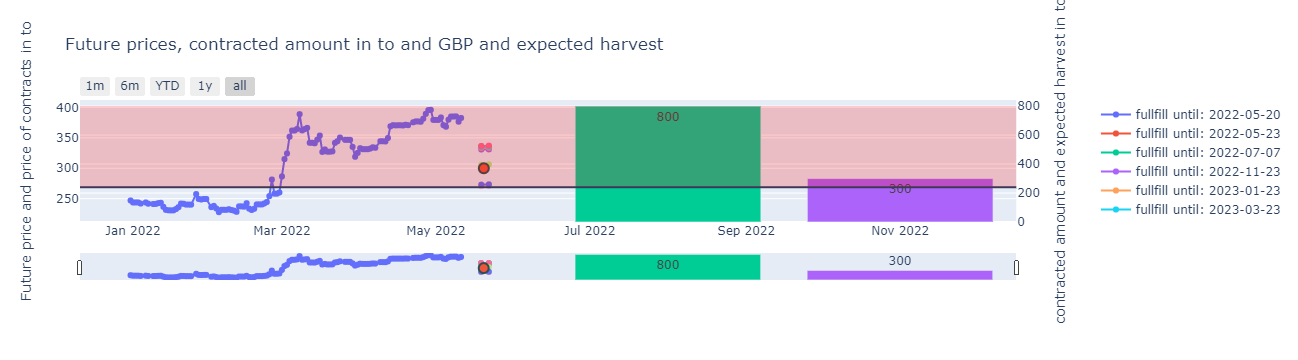

In [127]:
fig.show()